In [23]:
import pandas as pd
import datetime as dt
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from RandomForestForTimeSeriesRegressor import RandomForestForTimeSeriesRegressor, BLOCK_TYPES

In [24]:
dataset = pd.read_csv('yahoo_dataset_spy.csv')

In [25]:
dataset = dataset.dropna()
dataset = dataset.sort_values("Date")
dataset

,Date,Ticker,Open,High,Low,Close,Adj_close,Volume
7975,1 abr 1993,SPY,45.25,45.25,44.94,45.03,25.18,129500
7217,1 abr 1996,SPY,65.00,65.45,64.80,65.44,39.39,773400
6965,1 abr 1997,SPY,75.25,76.19,75.05,75.86,46.54,3210900
6712,1 abr 1998,SPY,110.31,111.08,109.41,110.83,68.98,2929000
6460,1 abr 1999,SPY,129.69,129.69,128.13,129.34,81.51,7683600
...,...,...,...,...,...,...,...,...
1318,9 sept 2019,SPY,299.14,299.24,297.16,298.20,273.03,51260300
1065,9 sept 2020,SPY,337.55,342.46,336.61,339.79,317.32,91462300
813,9 sept 2021,SPY,450.70,452.57,448.72,448.98,425.53,57970400
561,9 sept 2022,SPY,402.74,407.51,402.46,406.60,390.85,76706900


In [26]:
from dateutil import parser

# Diccionario para traducir meses en español a inglés
MESES_ESP = {
    "ene": "Jan", "feb": "Feb", "mar": "Mar", "abr": "Apr", "may": "May", "jun": "Jun",
    "jul": "Jul", "ago": "Aug", "sep": "Sep", "oct": "Oct", "nov": "Nov", "dic": "Dec"
}

# def corregir_fecha(fecha_str):
#     partes = fecha_str.split()
#     if len(partes) == 3:  # Asegurar que tiene día, mes y año
#         dia, mes, anio = partes
#         mes = MESES_ESP.get(mes.lower(), mes)  # Traducir mes al inglés
#         fecha_corregida = f"{dia} {mes} {anio}"
#         return parser.parse(fecha_corregida, dayfirst=True).toordinal()
#     return None  # Retorna None si no es válida
def corregir_fecha(fecha_str):
    try:
        partes = fecha_str.split()
        if len(partes) == 3:  # Asegurar que tiene día, mes y año
            dia, mes, anio = partes
            mes = MESES_ESP.get(mes.lower(), mes)  # Traducir mes al inglés
            fecha_corregida = f"{dia} {mes} {anio}"
            fecha_dt = parser.parse(fecha_corregida, dayfirst=True)  # Convertir a datetime
            return fecha_dt.strftime("%Y-%m-%d")  # Devolver en formato legible
    except Exception as e:
        print(f"Error con la fecha: {fecha_str} - {e}")
        return None  # Retorna None si hay un error

def actualizar_fecha(df, columna):
    df[columna] = df[columna].apply(lambda x: corregir_fecha(x) if pd.notna(x) else None)
    return df

dataset = actualizar_fecha(dataset, "Date")
dataset

,Date,Ticker,Open,High,Low,Close,Adj_close,Volume
7975,1993-04-01,SPY,45.25,45.25,44.94,45.03,25.18,129500
7217,1996-04-01,SPY,65.00,65.45,64.80,65.44,39.39,773400
6965,1997-04-01,SPY,75.25,76.19,75.05,75.86,46.54,3210900
6712,1998-04-01,SPY,110.31,111.08,109.41,110.83,68.98,2929000
6460,1999-04-01,SPY,129.69,129.69,128.13,129.34,81.51,7683600
...,...,...,...,...,...,...,...,...
1318,2019-09-09,SPY,299.14,299.24,297.16,298.20,273.03,51260300
1065,2020-09-09,SPY,337.55,342.46,336.61,339.79,317.32,91462300
813,2021-09-09,SPY,450.70,452.57,448.72,448.98,425.53,57970400
561,2022-09-09,SPY,402.74,407.51,402.46,406.60,390.85,76706900


In [27]:
def calculateFields(dataset):
    if 'Date' not in dataset:
        dataset['Date'] = dataset['date']
        dataset = dataset.drop(columns=["date"])
    if 'Adj Close' in dataset:
        dataset = dataset.drop(columns=['Adj Close'])
    if 'Adj Close' in dataset:
        dataset = dataset.drop(columns=['Adj_close'])
    dataset['Date'] = pd.to_datetime(dataset['Date'])
    dataset['DateOrdinal'] = dataset['Date'].map(dt.datetime.toordinal)
    dataset['average_price'] = dataset[['Low', 'High']].mean(axis=1)
    dataset['DayOfWeek'] = dataset['Date'].dt.dayofweek
    dataset['Month'] = dataset['Date'].dt.month
    dataset['Year'] = dataset['Date'].dt.year
    dataset['DayOfYear'] = dataset['Date'].dt.dayofyear
    dataset['WeekOfYear'] = dataset['Date'].dt.isocalendar().week

    dataset['is_start_of_month'] = (dataset['Date'].dt.day == 1).astype(int)
    dataset['is_end_of_month'] = (dataset['Date'] == dataset['Date'] + pd.offsets.MonthEnd(0)).astype(int)
    dataset['quarter'] = dataset['Date'].dt.quarter
    def get_season(month):
        if month in [12, 1, 2]:
            return 0#'winter'
        elif month in [3, 4, 5]:
            return 1#'spring'
        elif month in [6, 7, 8]:
            return 2#'summer'
        else:
            return 3#'autumn'
    dataset['season'] = dataset['Month'].apply(get_season)
    dataset['SerieNumber'] = (dataset['Date'] - dataset['Date'].min()).dt.days + 1


    days_ago = 30

    dataset["price_30_days_ago"] = dataset["average_price"].shift(days_ago)
    dataset["price_180_days_ago"] = dataset["average_price"].shift(180)
    dataset["price_365_days_ago"] = dataset["average_price"].shift(365)


    dataset = dataset.dropna().reset_index(drop=True)
    if 'Symbol' in dataset:
        dataset['Symbol'] = pd.factorize(dataset.Symbol)[0]
    else:
        dataset['Symbol'] = pd.factorize(dataset.Ticker)[0]
        dataset = dataset.drop(columns=['Ticker'])
    dataset = dataset.drop(columns=["Volume", "Close", "Open", "Low", "High", "Symbol"])

    return dataset

calculatedFields = ["DateOrdinal", "DayOfWeek", "Month", "Year", "DayOfYear", "WeekOfYear", "is_start_of_month", "is_end_of_month", "quarter",
                    "season", "SerieNumber", "price_30_days_ago", "price_180_days_ago", "price_365_days_ago"]
fieldsPrice = ["average_price"]


dataset = calculateFields(dataset)
dataset

,Date,Adj_close,DateOrdinal,average_price,DayOfWeek,Month,Year,DayOfYear,WeekOfYear,is_start_of_month,is_end_of_month,quarter,season,SerieNumber,price_30_days_ago,price_180_days_ago,price_365_days_ago
0,2003-07-10,66.10,731406,99.335,3,7,2003,191,28,0,0,3,2,3815,44.640,47.110,45.095
1,2006-07-10,89.07,732502,126.920,0,7,2006,191,28,0,0,3,2,4911,47.205,58.505,65.125
2,2007-07-10,107.92,732867,151.690,1,7,2007,191,28,0,0,3,2,5276,48.225,70.715,75.620
3,2008-07-10,91.41,733233,124.685,3,7,2008,192,28,0,0,3,2,5642,78.975,136.280,110.245
4,2009-07-10,65.90,733598,87.920,4,7,2009,191,28,0,0,3,2,6007,101.830,142.235,128.910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7649,2019-09-09,273.03,737311,298.200,0,9,2019,252,37,0,0,3,3,9720,95.435,390.685,199.065
7650,2020-09-09,317.32,737677,339.535,2,9,2020,253,37,0,0,3,3,10086,106.810,473.140,237.020
7651,2021-09-09,425.53,738042,450.645,3,9,2021,252,36,0,0,3,3,10451,144.900,44.685,273.330
7652,2022-09-09,390.85,738407,404.985,4,9,2022,252,36,0,0,3,3,10816,165.365,47.315,273.535


In [28]:
trainPercent = 80
trainSamples = (len(dataset.index) // 100) * trainPercent
testSamples = len(dataset.index) - trainSamples

In [29]:
def getRandomBlock(dataset0, blockDayRange):
    max_date = pd.to_datetime(dataset0['Date'].max())
    min_valid_date = max_date - pd.DateOffset(years=1)  # Fecha máxima menos un año
    
    valid_dates = dataset0[dataset0['Date'] <= min_valid_date]['Date']
    if valid_dates.empty:
        raise ValueError("No hay fechas válidas en el rango permitido.")
    
    random_start_date = np.random.choice(valid_dates)
    end_date = random_start_date + pd.DateOffset(days=blockDayRange)
    
    filtered_df = dataset0[(dataset0['Date'] >= random_start_date) & (dataset0['Date'] <= end_date)]
    return filtered_df

In [30]:
def getRandomTrainTestData(dataset0, daysRange, trainDays):
    blockDf = getRandomBlock(dataset0, daysRange)
    min_date = pd.to_datetime(dataset0['Date'].min())
    train_max_day = min_date + pd.DateOffset(days=trainDays)
    trainSamples = dataset0[dataset0['Date'] < train_max_day].shape[0]
    testSamples = len(dataset0.index) - trainSamples

    aux = dataset0.copy()
    aux = aux.drop("Date", axis=1)
    X = aux[calculatedFields].copy()
    aux = aux.drop(calculatedFields, axis=1)

    Y = aux.copy()

    X_train = X.iloc[:trainSamples]
    Y_train = Y.iloc[:trainSamples]
    X_test = X.iloc[-testSamples:]
    Y_test = Y.iloc[-testSamples:]

    return X_train, Y_train, X_test, Y_test

In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

basicRFPrecision = []
for i in range(50):
    X_train0, Y_train0, X_test0, Y_test0 = getRandomTrainTestData(dataset, 730, 365)
    basicRF = RandomForestRegressor(n_jobs=5, n_estimators=100, max_depth=10)
    basicRF.fit(X_train0, Y_train0)
    y_pred = basicRF.predict(X_test0)
    rmse0 = sqrt(mean_squared_error(Y_test0, y_pred))
    print(f"RMSE:")
    print(rmse0)
    basicRFPrecision.append(rmse0)

RMSE:
9.076570690863614
RMSE:
9.393770290957761
RMSE:
9.376697144237971
RMSE:
9.498320871804975
RMSE:
9.631575810235738
RMSE:
9.397437681183806
RMSE:
9.623491696891913
RMSE:
9.83069868767932
RMSE:
9.486238115624989
RMSE:
9.486244832734295
RMSE:
9.52097563220643
RMSE:
9.404610034196777
RMSE:
9.302684289101162
RMSE:
9.545301403039316
RMSE:
9.424388558394979
RMSE:
9.445414460579716
RMSE:
9.434958843364491
RMSE:
9.440287291994835
RMSE:
9.62942287623991
RMSE:
9.678240104937894
RMSE:
9.380159735084558
RMSE:
9.667820641516077
RMSE:
9.603881253294496
RMSE:
9.560207157481377
RMSE:
9.517230933103082
RMSE:
9.44906944327559
RMSE:
9.619799697496823
RMSE:
9.663115817075749
RMSE:
9.81162273894912
RMSE:
9.58651675952189
RMSE:
9.487424818576663
RMSE:
9.644092106491911
RMSE:
9.444036485426007
RMSE:
9.426121407873163
RMSE:
9.604187612247912
RMSE:
9.555806862784404
RMSE:
9.138785249093996
RMSE:
9.113712369532761
RMSE:
9.637565345942841
RMSE:
9.51772276241551
RMSE:
9.340271693409349
RMSE:
9.61510492069911


In [32]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [33]:
daysOfBlocks = 730
daysOfTraining = 365
X_train0, Y_train0, X_test0, Y_test0 = getRandomTrainTestData(dataset, daysOfBlocks, daysOfTraining)
totalSamplesAprox = X_train0.shape[0]
blockSizes = [totalSamplesAprox / 100, totalSamplesAprox / 50, totalSamplesAprox / 25, totalSamplesAprox / 10, totalSamplesAprox / 5]
for i in range(len(blockSizes)):
    blockSizes[i] = int(blockSizes[i])


In [34]:
def testRftsAndGetRmseByAlgorithm(dataset0, daysOfBlocks0, daysOfTraining0, block_size0, algorithm0):
    X_train0, Y_train0, X_test0, Y_test0 = getRandomTrainTestData(dataset0, daysOfBlocks0, daysOfTraining0)
    rfts = RandomForestForTimeSeriesRegressor(n_jobs=5, n_estimators=100, block_size=block_size0, max_depth=10, block_type=BLOCK_TYPES[algorithm0])
    rfts.fit(X_train0, Y_train0)
    y_pred = rfts.predict(X_test0)
    rmse0 = sqrt(mean_squared_error(Y_test0, y_pred))
    return rmse0

In [35]:
precisionNonOverlapping = dict()
for block_size in blockSizes:
    precisionNonOverlapping[block_size] = []
    for k in range(50):
        rmse0 = testRftsAndGetRmseByAlgorithm(dataset, daysOfBlocks, daysOfTraining, block_size, 0)
        print(f"RMSE: ({block_size}, {k})")
        print(rmse0)
        precisionNonOverlapping[block_size].append(rmse0)

RMSE: (2, 0)
9.280523348692116
RMSE: (2, 1)
9.445036669763548
RMSE: (2, 2)
9.24180579676358
RMSE: (2, 3)
9.197234228674178
RMSE: (2, 4)
9.545435595998187
RMSE: (2, 5)
9.368345853721975
RMSE: (2, 6)
9.273884251023281
RMSE: (2, 7)
9.311344729915005
RMSE: (2, 8)
9.324938034508508
RMSE: (2, 9)
9.369098198157156
RMSE: (2, 10)
9.199447764108308
RMSE: (2, 11)
9.382619254123664
RMSE: (2, 12)
9.415677684809731
RMSE: (2, 13)
9.311528333284206
RMSE: (2, 14)
9.384623543329136
RMSE: (2, 15)
9.416404901336554
RMSE: (2, 16)
9.213725727210795
RMSE: (2, 17)
9.098788167294273
RMSE: (2, 18)
9.184604055123147
RMSE: (2, 19)
9.25544895810305
RMSE: (2, 20)
9.374072612557885
RMSE: (2, 21)
9.38250200965687
RMSE: (2, 22)
9.413472381853852
RMSE: (2, 23)
9.242699073894904
RMSE: (2, 24)
9.221955461577242
RMSE: (2, 25)
9.248004577382838
RMSE: (2, 26)
9.066098827392466
RMSE: (2, 27)
9.336176246154846
RMSE: (2, 28)
9.460110395777496
RMSE: (2, 29)
9.31659130233571
RMSE: (2, 30)
9.429454849422365
RMSE: (2, 31)
9.460080

In [36]:
def getGraphData(presitionDataArray):
    all_arr = [basicRFPrecision]
    ticksIdx = [0]
    ticksNames = ["RF"]
    idx = 0
    for blockSize in blockSizes:
        
        data0 = []
        for r in presitionDataArray[blockSize]:
            data0.append(r)

        all_arr.append(data0)
        idx += 1
        ticksIdx.append(idx)
        ticksNames.append(str(blockSize))

    return all_arr, ticksIdx, ticksNames

Text(0, 0.5, 'RMSE')

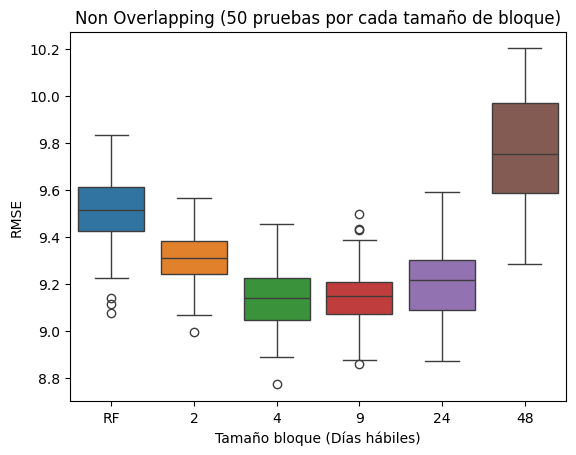

In [37]:
from matplotlib import pyplot as plt

all_arr, ticksIdx, ticksNames = getGraphData(precisionNonOverlapping)

sns.boxplot(data=all_arr)
plt.xticks(ticksIdx, ticksNames)
plt.title("Non Overlapping (50 pruebas por cada tamaño de bloque)")
plt.xlabel("Tamaño bloque (Días hábiles)")
plt.ylabel("RMSE")

In [38]:
precisionMovingBlock = dict()
for block_size in blockSizes:
    precisionMovingBlock[block_size] = []
    for k in range(50):
        rmse0 = testRftsAndGetRmseByAlgorithm(dataset, daysOfBlocks, daysOfTraining, block_size, 1)
        print(f"RMSE: ({block_size}, {k})")
        print(rmse0)
        precisionMovingBlock[block_size].append(rmse0)

RMSE: (2, 0)
9.790377433948098
RMSE: (2, 1)
9.587431173980496
RMSE: (2, 2)
9.225054232820913
RMSE: (2, 3)
9.60176288335045
RMSE: (2, 4)
9.185243626698947
RMSE: (2, 5)
9.280141510520663
RMSE: (2, 6)
9.73599771176809
RMSE: (2, 7)
9.570599823583708
RMSE: (2, 8)
9.536976884976546
RMSE: (2, 9)
9.45986703548607
RMSE: (2, 10)
9.721962408477765
RMSE: (2, 11)
9.399637284112778
RMSE: (2, 12)
9.256758187989135
RMSE: (2, 13)
9.298937308323037
RMSE: (2, 14)
9.761779412871018
RMSE: (2, 15)
9.49291088330192
RMSE: (2, 16)
9.4456588043541
RMSE: (2, 17)
9.64394173928227
RMSE: (2, 18)
9.45838397976513
RMSE: (2, 19)
9.279819017859285
RMSE: (2, 20)
9.324717995869545
RMSE: (2, 21)
9.550118710768103
RMSE: (2, 22)
9.419532902227836
RMSE: (2, 23)
9.326099900374851
RMSE: (2, 24)
9.605478167081776
RMSE: (2, 25)
9.515922604712875
RMSE: (2, 26)
9.29148847800394
RMSE: (2, 27)
9.669302117896772
RMSE: (2, 28)
9.293433039574099
RMSE: (2, 29)
9.205893387977564
RMSE: (2, 30)
9.47916935967696
RMSE: (2, 31)
9.388082275193

Text(0, 0.5, 'RMSE')

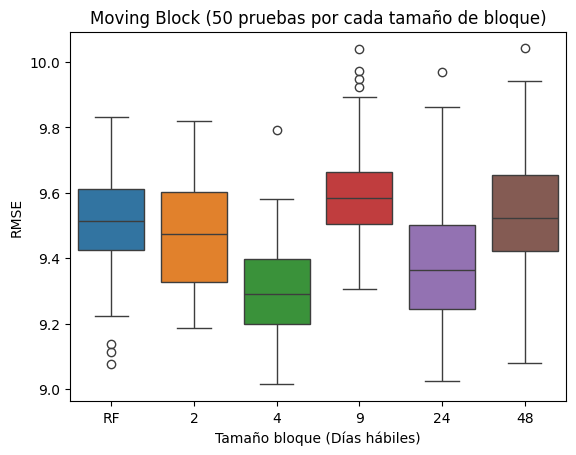

In [39]:
all_arr, ticksIdx, ticksNames = getGraphData(precisionMovingBlock)

sns.boxplot(data=all_arr)
plt.xticks(ticksIdx, ticksNames)
plt.title("Moving Block (50 pruebas por cada tamaño de bloque)")
plt.xlabel("Tamaño bloque (Días hábiles)")
plt.ylabel("RMSE")

In [40]:
precisionCircularBlock = dict()
for block_size in blockSizes:
    precisionCircularBlock[block_size] = []
    for k in range(50):
        rmse0 = testRftsAndGetRmseByAlgorithm(dataset, daysOfBlocks, daysOfTraining, block_size, 2)
        print(f"RMSE: ({block_size}, {k})")
        print(rmse0)
        precisionCircularBlock[block_size].append(rmse0)

RMSE: (2, 0)
9.391180215625965
RMSE: (2, 1)
9.340061303302953
RMSE: (2, 2)
9.463875627716043
RMSE: (2, 3)
9.378945785836812
RMSE: (2, 4)
9.554084778319773
RMSE: (2, 5)
9.208741049659919
RMSE: (2, 6)
9.433348537483793
RMSE: (2, 7)
9.36726601735275
RMSE: (2, 8)
9.537888490803535
RMSE: (2, 9)
9.59252985184038
RMSE: (2, 10)
9.393867661161192
RMSE: (2, 11)
9.436680840971176
RMSE: (2, 12)
9.303013557158934
RMSE: (2, 13)
9.480148199406665
RMSE: (2, 14)
9.326284072716431
RMSE: (2, 15)
9.560135030155019
RMSE: (2, 16)
9.56861081032396
RMSE: (2, 17)
9.402129324291733
RMSE: (2, 18)
9.469922784398852
RMSE: (2, 19)
9.48453483007542
RMSE: (2, 20)
9.242285941123912
RMSE: (2, 21)
9.398666801741207
RMSE: (2, 22)
9.491149205116848
RMSE: (2, 23)
9.320447785218265
RMSE: (2, 24)
9.543497608573253
RMSE: (2, 25)
9.34073978244645
RMSE: (2, 26)
9.526772969415994
RMSE: (2, 27)
9.45724067425751
RMSE: (2, 28)
9.396779565739621
RMSE: (2, 29)
9.314843541269907
RMSE: (2, 30)
9.55141768404767
RMSE: (2, 31)
9.584033084

Text(0, 0.5, 'RMSE')

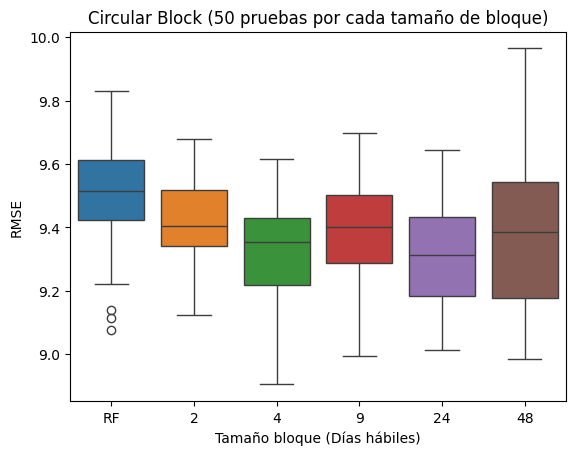

In [41]:
all_arr, ticksIdx, ticksNames = getGraphData(precisionCircularBlock)

sns.boxplot(data=all_arr)
plt.xticks(ticksIdx, ticksNames)
plt.title("Circular Block (50 pruebas por cada tamaño de bloque)")
plt.xlabel("Tamaño bloque (Días hábiles)")
plt.ylabel("RMSE")

Text(33.972222222222214, 0.5, 'RMSE')

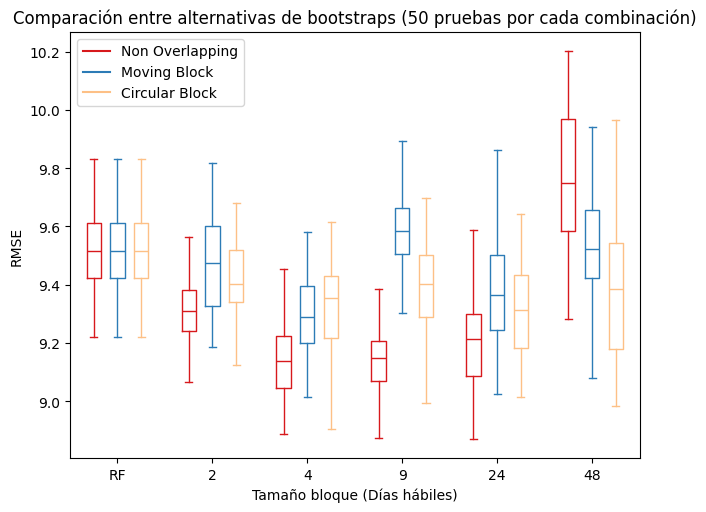

In [42]:
all_arr, ticksIdx, ticksNames = getGraphData(precisionNonOverlapping)
all_arr1, ticksIdx, ticksNames = getGraphData(precisionMovingBlock)
all_arr2, ticksIdx, ticksNames = getGraphData(precisionCircularBlock)

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure()

bp0 = plt.boxplot(all_arr, positions=np.array(range(len(all_arr)))*2.0-0.5, sym='', widths=0.3)
bp1 = plt.boxplot(all_arr1, positions=np.array(range(len(all_arr1)))*2.0, sym='', widths=0.3)
bp2 = plt.boxplot(all_arr2, positions=np.array(range(len(all_arr1)))*2.0+0.5, sym='', widths=0.3)
set_box_color(bp0, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bp1, '#2C7BB6')
set_box_color(bp2, '#fdc086')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Non Overlapping')
plt.plot([], c='#2C7BB6', label='Moving Block')
plt.plot([], c='#fdc086', label='Circular Block')
plt.legend()

plt.xticks(range(0, len(ticksNames) * 2, 2), ticksNames)
# plt.xlim(-2, len(ticks)*2)
#plt.ylim(34, 55)
plt.tight_layout()
plt.title("Comparación entre alternativas de bootstraps (50 pruebas por cada combinación)")
plt.xlabel("Tamaño bloque (Días hábiles)")
plt.ylabel("RMSE")